<a href="https://colab.research.google.com/github/tompoles/Portfolio/blob/master/Edinbourgh_bikes_engeto_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
!pip install pymysql
conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(conn_string)
query = """select * from edinburgh_bikes"""
edinburgh_bikes_df = pd.read_sql(query, alchemy_conn)

     |████████████████████████████████| 51kB 4.4MB/s 


*   Identifikujte aktivní a neaktivní stanice











In [ ]:
edinburgh_bikes_df

In [3]:
# pocet pouziti kazde jedne stanice
df1 = edinburgh_bikes_df.groupby('start_station_name', as_index=False).agg({'index':['count']})
df2 = edinburgh_bikes_df.groupby('end_station_name', as_index=False).agg({'index':'count'})

In [ ]:
# udelat deskriptivni statistiku co bude pod 25 je nevyuzite, na 75 hodne vyuzite
df1.describe(), df2.describe()

In [ ]:
# vyfiltrovani vyuzitych a nevyuzitych stanic
  # filtr startovacich stanic na zaklade 25%+ vyuzitelnosti
df1['usability'] = np.where(df1['index'] > df1['index'].quantile(.25), 'usefull','expendable')
  # filtr konecnych stanic na zaklade 25%+ vyuzitelnosti
df2['usability'] = np.where(df2['index'] > df2['index'].quantile(.25), 'usefull','expendable')
# vysledny seznam stanic
df1[df1['usability'] == 'usefull']

In [ ]:
# # Determinovani nejmene frekventovanych stanic na zaklade 25% kvantilu.
Usa_df1 = df1[df1['usability'] == 'expendable'].iloc[:, :-1].sort_values([('index','count')], ascending=False).rename(columns=({'start_station_name':'Station name'}))
Usa_df1
Usa_df2 = df2[df2['usability'] == 'expendable'].iloc[:, :-1].rename(columns=({'end_station_name':'Station name'}))
Usa_df = Usa_df1.merge(Usa_df2, on='Station name').drop(columns=[('Station name','')]).rename(columns={'index':'End station usage', 
                                                                                                      ('index','count'):'Start station usage',
                                                                                                      "('Station name','')":"Station"})

In [ ]:
# # Determinovani frekventovanych stanic na zaklade 25% kvantilu. - uzitecne stanice
Usa_df12 = df1[df1['usability'] == 'usefull'].iloc[:, :-1].sort_values([('index','count')], ascending=False).rename(columns=({'start_station_name':'Station name'}))
Usa_df12
Usa_df22 = df2[df2['usability'] == 'usefull'].iloc[:, :-1].rename(columns=({'end_station_name':'Station name'}))
Usa_df2 = Usa_df12.merge(Usa_df22, on='Station name').drop(columns=[('Station name','')]).rename(columns={'index':'End station usage', 
                                                                                                      ('index','count'):'Start station usage',
                                                                                                      "('Station name','')":"Station"})
Usa_df2


*   identifikujte nejfrekventovanější stanice






In [8]:
# Determinovani frekventovanych stanic na zaklade 75% kvantilu.
df1['frq'] = np.where(df1['index'] > df1['index'].quantile(.75), '+', 0)
df2['frq'] = np.where(df2['index'] > df2['index'].quantile(.75), '+', 0)

In [ ]:
# uprava vysledne tabulky nejfrektovanejsich stanic
frq_df1 = df1.iloc[:, :-2][df1['frq'] == '+'].rename(columns={'start_station_name':'Station name'}).sort_values([('index','count')], ascending=False)
frq_df2 = df2.iloc[:, :-2][df2['frq'] == '+'].rename(columns={'end_station_name':'Station name'})
frq_df = frq_df1.merge(frq_df2, on='Station name').drop(columns=[('Station name','')]).rename(columns={'index':'End station usage', 
                                                                                                      ('index','count'):'Start station usage',
                                                                                                      "('Station name','')":"Station"})
frq_df.info()



*   identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí




In [ ]:
# Station diff, kde chybi/prebyvaji kola
Usa_df2['Station diff'] = Usa_df2['End station usage'] - Usa_df2['Start station usage']
Usa_df2.sort_values(by=['Station diff'])

*   Spočítejte vzdálenosti mezi jednotlivými stanicemi




*  jak dlouho trvá jedna výpůjčka? Najděte odlehlé hodnoty, zobrazte histogram




In [11]:
Dist_df = edinburgh_bikes_df[['start_station_name',	'start_station_latitude', 'start_station_longitude', 'end_station_name', 'end_station_latitude','end_station_longitude', 'duration']]
Dist_df.rename(columns={'start_station_name':'Start station',	'start_station_latitude':'SLat', 'start_station_longitude':'Slong', 'end_station_name':'End station', 'end_station_latitude':'Elat','end_station_longitude':'Elong'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# Vyuziti funkce haversine na spocitani vzdalenosti na zaklade sirek a delek
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
# Uprava vysledneho DF
Dist_df['distance[km]'] = haversine_np(Dist_df['SLat'],Dist_df['Slong'],Dist_df['Elat'],Dist_df['Elong']).round(2)
Dist_df.drop(columns=['SLat','Slong',	'Elat',	'Elong'], inplace=True)
Dist_df['Duration[min]'] = (Dist_df['duration']/60).round(2)

In [ ]:
Dist_df.drop(columns='duration', inplace=True)

*  Jak dlouho trvá jedna výpůjčka? Najděte odlehlé hodnoty



In [ ]:
df1 = Dist_df[(Dist_df['distance[km]'] < 280)]

In [ ]:
# df[(df['safety'] <= 0.97) & ((df['rent'] > 900) & (df['rent'] < 1100))]
DF = Dist_df[(((Dist_df['distance[km]'] > 0) & (Dist_df['distance[km]'] < 280))) & (((Dist_df['Duration[min]'] > 1.02) & (Dist_df['Duration[min]'] < 500.05)))] 
DF.describe()

*    Zobrazte histogram



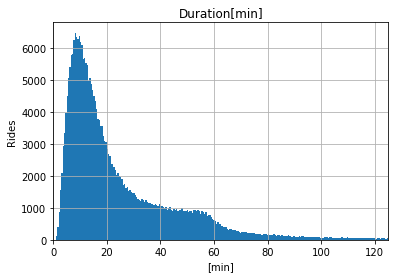

In [18]:
plt.hist(DF['Duration[min]'], bins=1000)
plt.xlim(0, 125,0.1)
plt.xlabel('[min]')
plt.ylabel('Rides')
plt.title('Duration[min]')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
sns.pairplot(DF,
             plot_kws={'facecolor': 'red',
                       'alpha': 0.3}, 
             height=4)
plt.show()

*   Zobrazte vývoj poptávky po půjčování kol v čase



In [20]:
query = """select * from edinburgh_weather"""
edinburgh_weather_df = pd.read_sql(query, alchemy_conn)

In [ ]:
edinburgh_weather_df

In [67]:
ew_df1 = edinburgh_weather_df[['date', 'feels']]
ew_df2 = ew_df1.replace('\u00b0','', regex=True)

In [ ]:
EW_DF = ew_df2.replace('c', '', regex=True)
EW_DF['feels'] = pd.to_numeric(EW_DF['feels'])
EW_DF

In [ ]:
EW_DF = EW_DF[(EW_DF['date'] >= '2018-09-15')]
EW_DF = EW_DF.groupby('date').agg({'feels':'mean'}).round(0)
EW_DF

In [ ]:
df_dem

In [ ]:
idx = pd.date_range(df_dem['date'], periods=5, freq='H')
ts = pd.Series(range(len(idx)), index=idx)
ts

In [ ]:
edinburgh_bikes_df

In [ ]:
plt.plot(df_d, label='Bike demand')
plt.title('Bike demand in time (cumulative)', x=1, loc='right', fontstyle='italic')
plt.xlabel('$Rents$', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.legend(fontsize=14, ncol=2)
plt.grid()
plt.show()

In [103]:
# Rozdeleni sloupce Start_at na "date" - datum a "time" - cas
from operator import attrgetter

fields = ['date', 'time']
df = edinburgh_bikes_df.join(pd.concat(attrgetter(*fields)(edinburgh_bikes_df['started_at'].dt), axis=1, keys=fields))
df.drop(columns=['started_at'], inplace=True)
DF_dem =df[['date', 'time','start_station_name', 'end_station_name', 'duration']]
df_dem = DF_dem .groupby('date', as_index=False).agg({'start_station_name':'count'}).rename(columns={'start_station_name':'Rent count'})

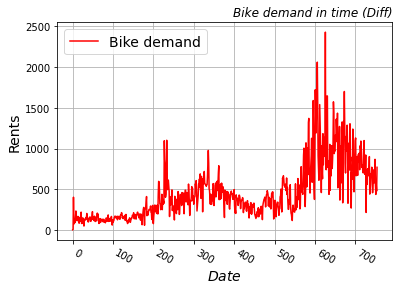

In [105]:
# graf vyuziti kol v case
plt.plot(df_dem['Rent count'], label='Bike demand', color='red')
# plt.plot(ew_df1, label='Bike demand', color='blue')
plt.title('Bike demand in time (Diff)', x=1, loc='right', fontstyle='italic')
plt.xlabel('$Date$', fontsize=14)
plt.ylabel('Rents', fontsize=14)
plt.xticks(rotation=-30, ha='left')
plt.legend(fontsize=14, ncol=2)
plt.grid()
plt.show()

In [ ]:
# graf vyuziti kol v case
plt.plot(EW_DF['feels'], label='Bike demand', color='red')
plt.plot(df_dem, label='Bike demand', color='blue')
plt.title('Bike demand in time (Diff)', x=1, loc='right', fontstyle='italic')
plt.xlabel('$Date$', fontsize=14)
plt.ylabel('Rents', fontsize=14)
plt.xticks(rotation=-30, ha='left')
plt.legend(fontsize=14, ncol=2)
plt.grid()
plt.show()

In [89]:
plt.hist(EW_DF['feels'], bins=30)
plt.plot(df_dem)
plt.show()

ValueError: ignored


*  identifikujte příčiny výkyvů poptávky

